In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
#print(os.getcwd())
#if os.path.basename(os.getcwd()) != 'NeuroCurve': os.chdir('NeuroCurve')

# Processing

In [2]:
os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")
"Drops any unnecessary features of the original dataset"
def pre_process():
    usableCSV = NeuroCurveOG.drop(columns=["PatientID", "Diabetes", "CardiovascularDisease", "DoctorInCharge", "Depression", "Depression", "SystolicBP", "DiastolicBP"])
    usableCSV.to_csv('CSV/output_CSVs/processed.csv')
pre_process()
usableCSV = pd.read_csv('CSV/output_CSVs/processed.csv')
os.chdir('NeuroPy')

X = usableCSV.drop(columns=['Diagnosis', 'Unnamed: 0'])
y = usableCSV['Diagnosis']

categorical_cols = ['Gender', 'Ethnicity', 'FamilyHistoryAlzheimers']
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding

''' Scale features '''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Model Test Split


In [3]:
''' ----------- Train/Test Split ----------- '''
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Training

In [67]:
''' ----------- Logistic Model Training ----------- '''
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

'''------------- Decision Tree Model Training ---------'''
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_prob_tree = tree.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred_tree)

'''------------ Mythical Forest Model Training---------'''
forest = RandomForestClassifier(max_features='sqrt', n_estimators=len(X_train), random_state=42)
forest.fit(X_train, y_train)
print("Number of trees in the Mythical Forest: " + str(len(forest.estimators_)))

'''---------- Forest K-Fold Model Training --------'''
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(forest, X_scaled, y, cv=kf, scoring='accuracy')
print("Cross-validated accuracy:", scores.mean())

Number of trees in the Mythical Forest: 1719
Cross-validated accuracy: 0.9502086502934144


# Analysis

In [68]:
''' ----------- Evaluation ----------- '''
y_prob = model.predict_proba(X_test)
print("Predicted probabilities for the first 5 examples:\n", y_prob[:5])
y_pred = model.predict(X_test)
print(f"y_pred: {y_pred[:5]}")
print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


y_prob_forest = forest.predict_proba(X_test)
print("Predicted probabilities for the first 5 examples:\n", y_prob_forest[:5])
y_pred_forest = forest.predict(X_test)
print(f"y_pred: {y_pred_forest[:5]}")
print(f"y_test: {y_test.values[:5]}")
accuracy = accuracy_score(y_test, y_pred_forest)
print(f"Accuracy: {accuracy * 100:.2f}%")


Predicted probabilities for the first 5 examples:
 [[0.15301974 0.84698026]
 [0.72028516 0.27971484]
 [0.05358372 0.94641628]
 [0.46517875 0.53482125]
 [0.0013241  0.9986759 ]]
y_pred: [1 0 1 1 1]
y_test: [1 1 1 1 1]
Accuracy: 81.40%
Predicted probabilities for the first 5 examples:
 [[0.15357766 0.84642234]
 [0.85747528 0.14252472]
 [0.24723677 0.75276323]
 [0.52181501 0.47818499]
 [0.08551483 0.91448517]]
y_pred: [1 0 1 0 1]
y_test: [1 1 1 1 1]
Accuracy: 94.88%


# Visualization

### Logistic Regression Confusion Matrix

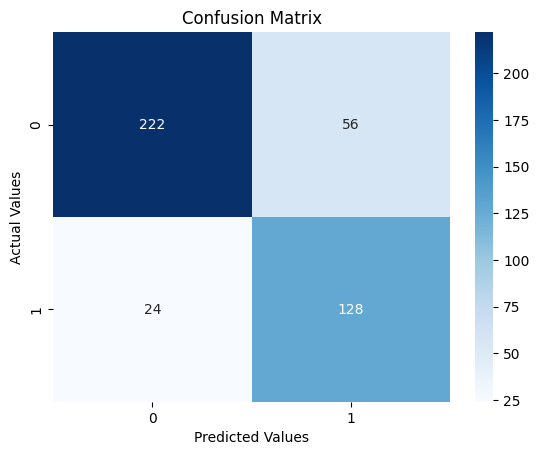

In [69]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

### Classification Report: Logistic Regression

In [70]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       278
           1       0.70      0.84      0.76       152

    accuracy                           0.81       430
   macro avg       0.80      0.82      0.80       430
weighted avg       0.83      0.81      0.82       430



### Mythical Forest Confusion Matrix

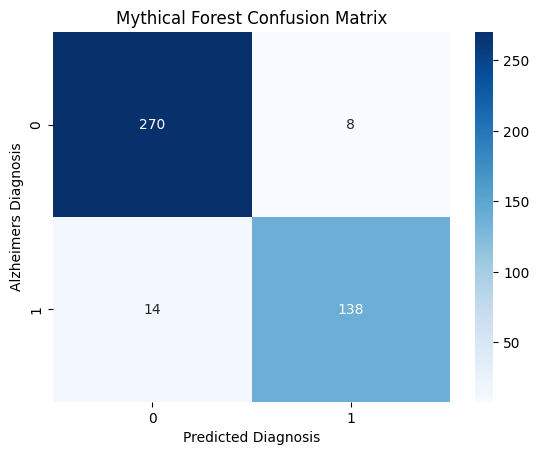

In [71]:
cm1 = confusion_matrix(y_test, y_pred_forest)
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues")
plt.title("Mythical Forest Confusion Matrix")
plt.ylabel("Alzheimers Diagnosis")
plt.xlabel("Predicted Diagnosis")
plt.show()

### Classification Report: Mythical Forest

In [9]:
print("Classification Report:")
print(classification_report(y_test, y_pred_forest))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1       0.95      0.91      0.93       152

    accuracy                           0.95       430
   macro avg       0.95      0.94      0.94       430
weighted avg       0.95      0.95      0.95       430



### Logistic Regression ROC Curve

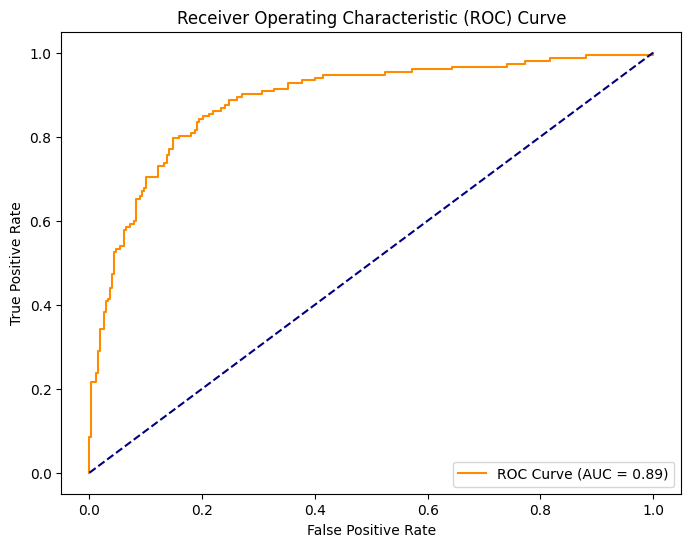

In [10]:
y_prob_class1 = y_prob[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_class1)
roc_auc = roc_auc_score(y_test, y_prob_class1)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Mythical Forest ROC Curve

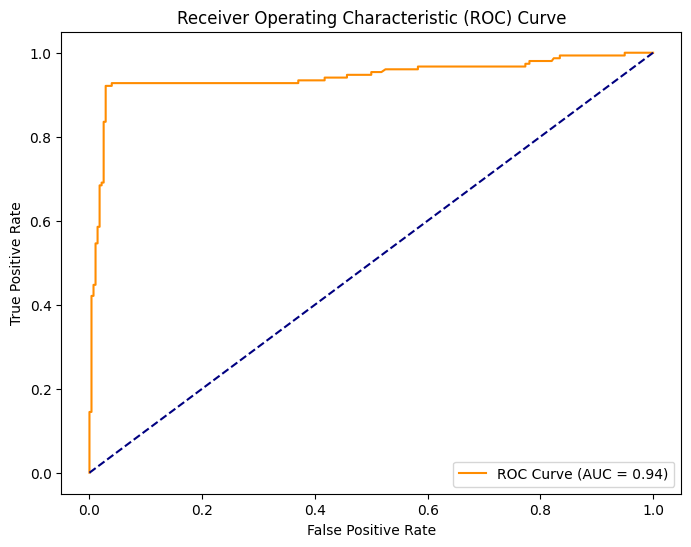

In [11]:
y_prob_forest = y_prob_forest[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_forest)
roc_auc = roc_auc_score(y_test, y_prob_forest)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:



"""
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}
grid = GridSearchCV(LogisticRegression(class_weight='balanced', max_iter=1000), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
"""

'\nparam_grid = {\n    \'C\': [0.01, 0.1, 1, 10],\n    \'penalty\': [\'l1\', \'l2\'],\n    \'solver\': [\'liblinear\']\n}\ngrid = GridSearchCV(LogisticRegression(class_weight=\'balanced\', max_iter=1000), param_grid, cv=5, scoring=\'roc_auc\')\ngrid.fit(X_train, y_train)\nprint("Best Parameters:", grid.best_params_)\n'